In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'tachibana_mouse'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [149]:
hparams = HParams(
    num_mel_bins = 32,
    butter_lowcut = 20000,
    butter_highcut = 124000,
    mel_lower_edge_hertz = 20000,
    mel_upper_edge_hertz = 124000,
    win_length_ms = .5,
    hop_length_ms = .1,
    n_fft = 1024,
    ref_level_db = 20,
    min_level_db = -85,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.75, "offset": 1e-10},
    reduce_noise=True,
    noise_reduce_kwargs = {"n_std_thresh": 2.0, "prop_decrease":0.8}
)

In [150]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

#### Create dataset based upon JSON

In [151]:
from joblib import Parallel, delayed
n_jobs = 1; verbosity = 10

In [10]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished


3170

In [11]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key
0,1.9770,1.9863,ClnBALB124,0,ClnBALB124-4vsBALBfe
1,2.0774,2.0884,ClnBALB124,0,ClnBALB124-4vsBALBfe
2,2.1985,2.2046,ClnBALB124,0,ClnBALB124-4vsBALBfe


### get audio for dataset

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/signalprocessing/create_spectrogram_dataset.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for st, et in zip(syllable_df.start_time.values, syllable_df.end_time.values)
/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/signalprocessing/create_spectrogram_dataset.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  syllable_df["rate"] = rate
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 10.9min finished


3170

In [13]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate
0,1.9770,1.9863,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[0.00012935064, 0.0003061041, 0.00011063961, -...",250000
1,2.0774,2.0884,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.00011886793, -0.00011039264, -1.8826695e-0...",250000
2,2.1985,2.2046,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.0001612896, 0.00070529454, 0.0003123867, -...",250000


In [14]:
syllable_df.indvi.values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
sylls = syllable_df.audio.values

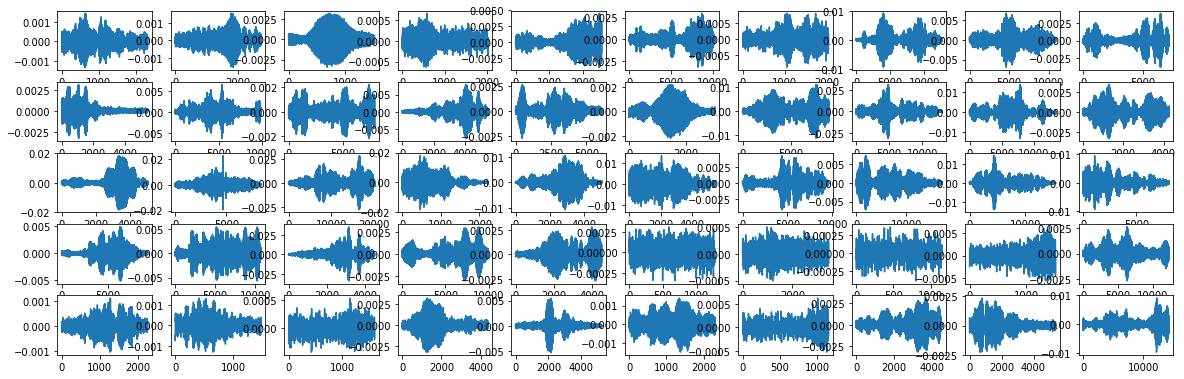

In [16]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [152]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [153]:
n_jobs = -1; verbosity = 10

In [154]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [155]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0214s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0214s.) Setting batch_size=334.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s


[Parallel(n_jobs=-1)]: Done 3170 out of 3170 | elapsed:    6.4s finished


### Rescale spectrogram
- using log rescaling

In [156]:
log_scaling_factor = 10

In [157]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0835s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0116s.) Setting batch_size=136.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1130s.) Setting batch_size=480.


[Parallel(n_jobs=-1)]: Done 3170 out of 3170 | elapsed:    1.1s finished


(25.0, 10) (320, 800) 25.0 32 800


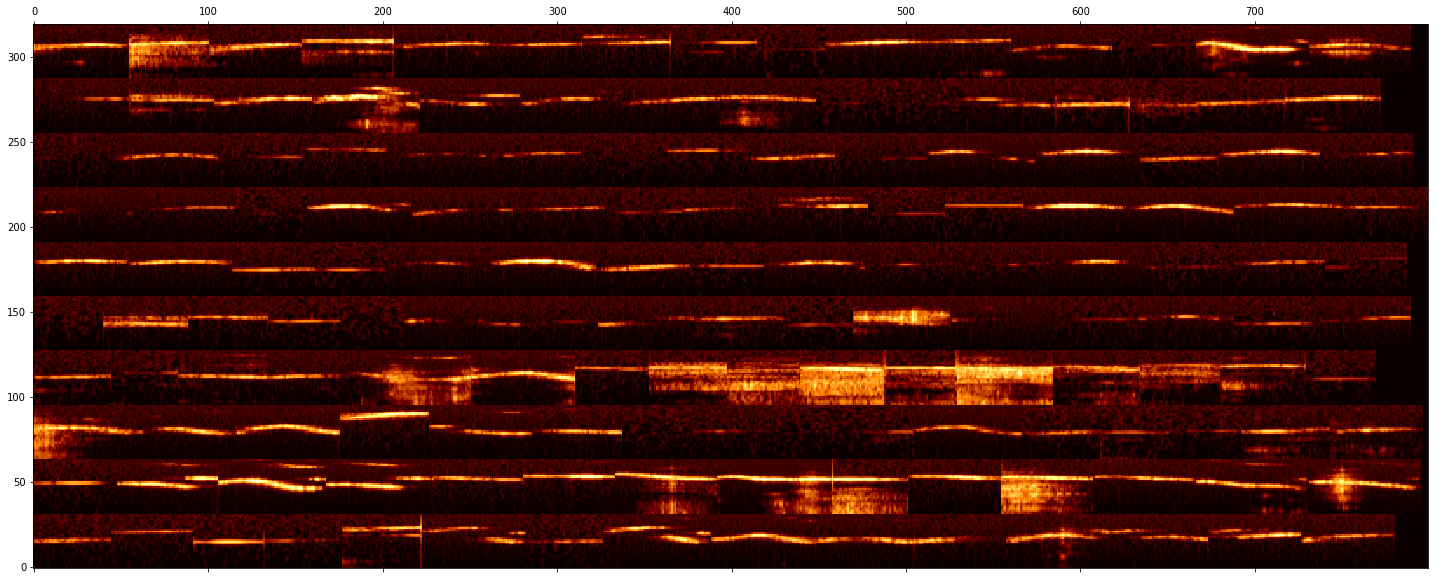

In [158]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Mask/threshold spectrograms to remove noise

In [159]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # Mask spectrograms
    if dataset.hparams.mask_spec:
        syllables_spec = parallel(
            delayed(mask_spec)(syllable, **dataset.hparams.mask_spec_kwargs)
            for syllable in tqdm(
                syllables_spec,
                total=len(syllables_rate),
                desc="masking spectrograms",
                leave=False,
            )
        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0120s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1413s.) Setting batch_size=90.
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 623 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done 3170 out of 3170 | elapsed:    3.0s finished


(25.0, 10) (320, 800) 25.0 32 800


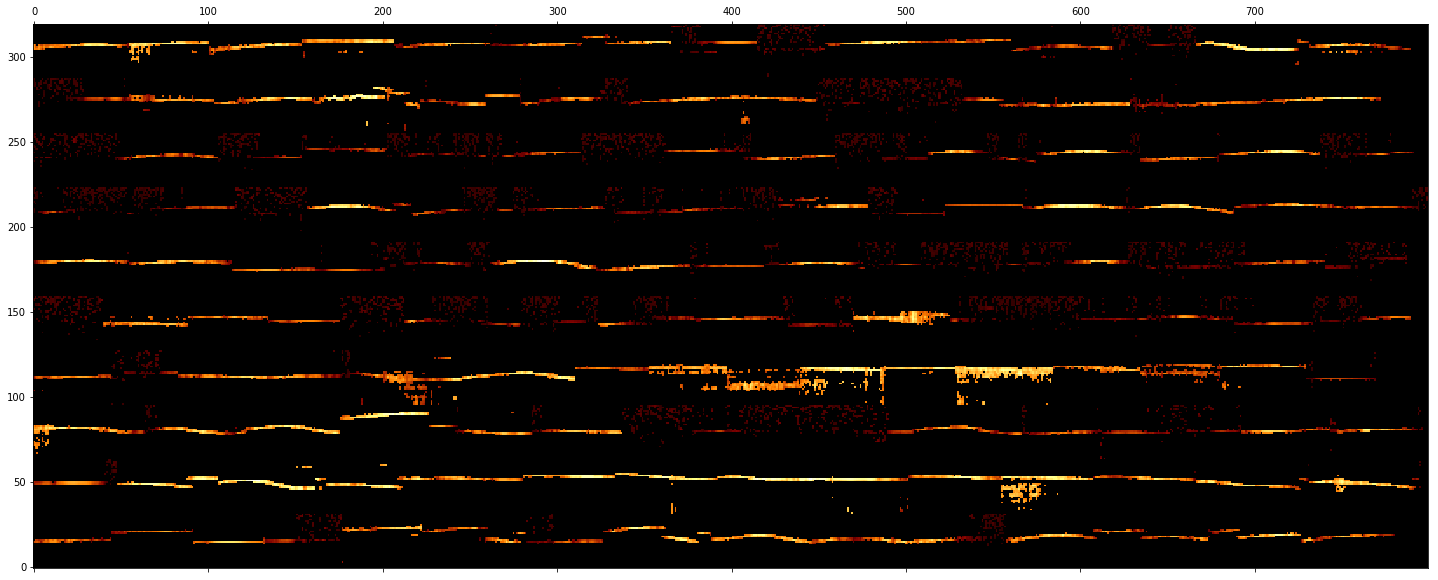

In [160]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [161]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

(array([401., 290., 340., 450., 514., 518., 273., 242., 101.,  41.]),
 array([37. , 41.2, 45.4, 49.6, 53.8, 58. , 62.2, 66.4, 70.6, 74.8, 79. ]),
 <a list of 10 Patch objects>)

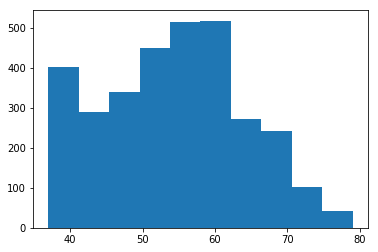

In [162]:
plt.hist(syll_lens)

In [163]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0265s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0999s.) Setting batch_size=56.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    0.3s


[Parallel(n_jobs=-1)]: Done 3170 out of 3170 | elapsed:    0.5s finished


(25.0, 10) (320, 800) 25.0 32 800


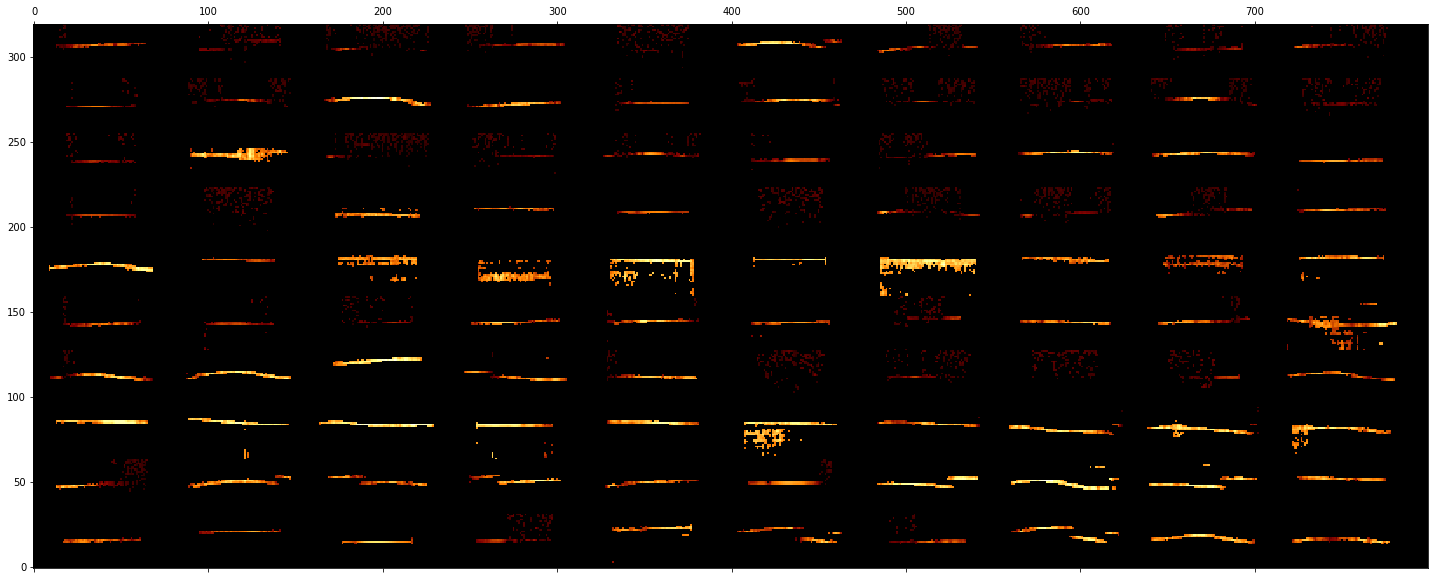

In [164]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### view indv spectrogram

In [165]:
syllable_df['spectrogram'] = syllables_spec

In [166]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,1.9770,1.9863,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[0.00012935064, 0.0003061041, 0.00011063961, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2.0774,2.0884,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.00011886793, -0.00011039264, -1.8826695e-0...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.1985,2.2046,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.0001612896, 0.00070529454, 0.0003123867, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [167]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,1.9770,1.9863,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[0.00012935064, 0.0003061041, 0.00011063961, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2.0774,2.0884,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.00011886793, -0.00011039264, -1.8826695e-0...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.1985,2.2046,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.0001612896, 0.00070529454, 0.0003123867, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Text(0.5, 1.0, 'min')

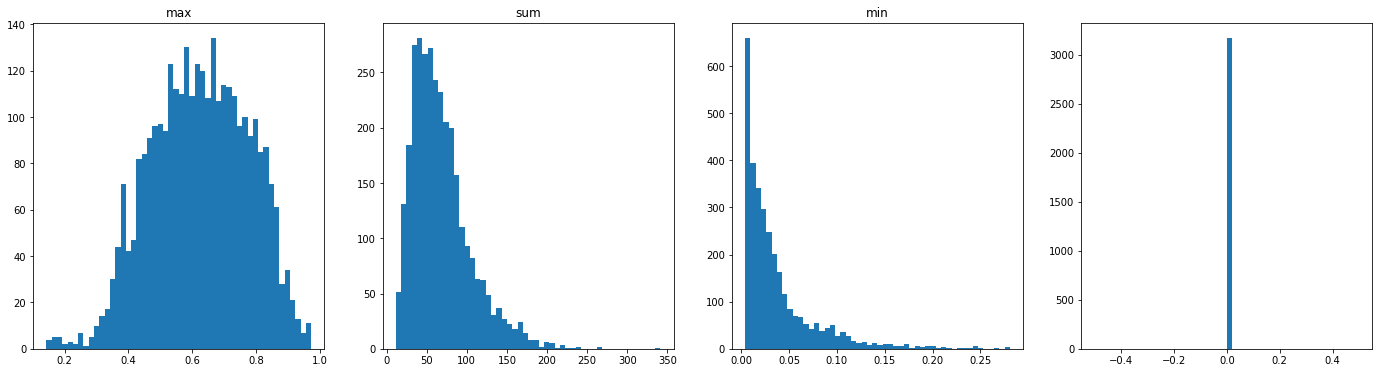

In [168]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[2].set_title('min')


ClnBALB124 203
(25.0, 5) (160, 800) 25.0 32 800


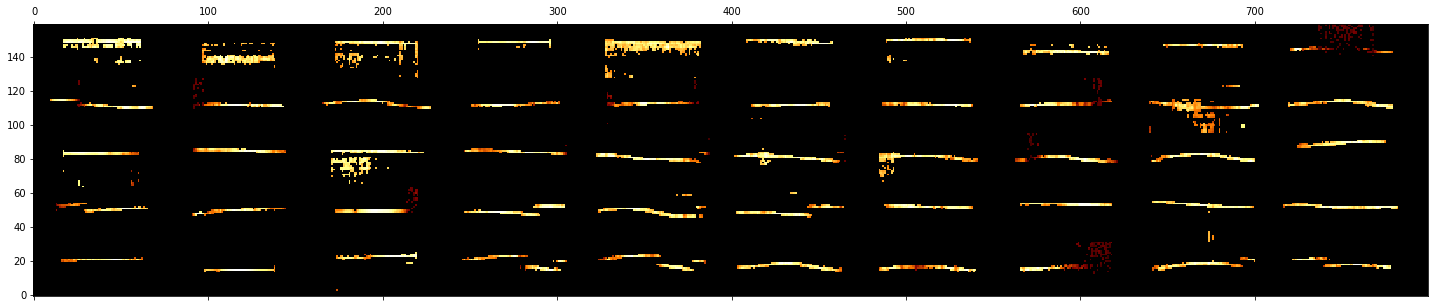

Can3_1 119
(25.0, 5) (160, 800) 25.0 32 800


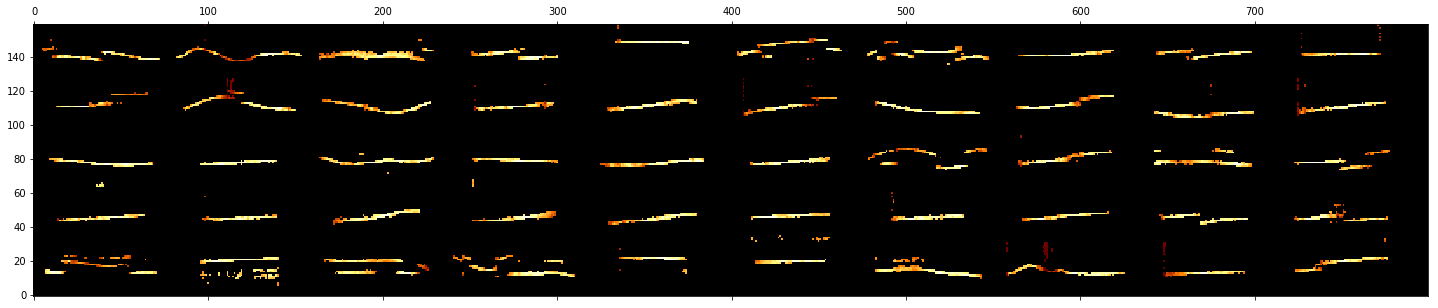

Aco65_1 383
(25.0, 5) (160, 800) 25.0 32 800


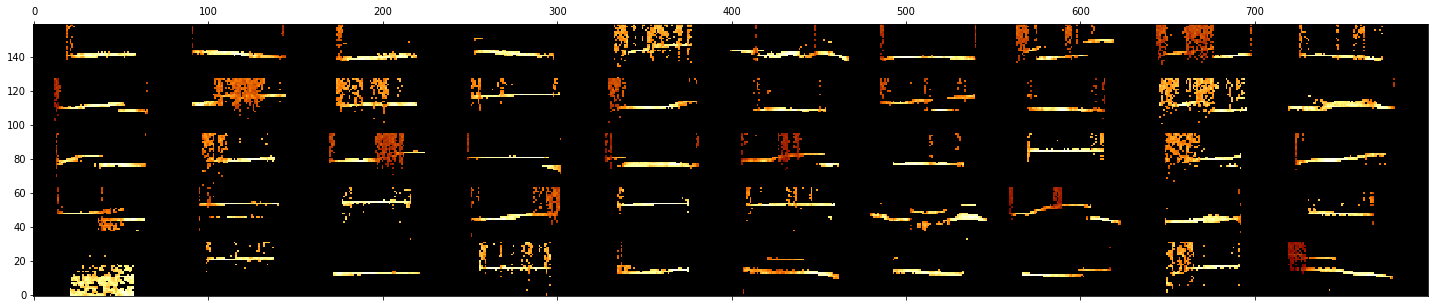

Aco59_2 418
(25.0, 5) (160, 800) 25.0 32 800


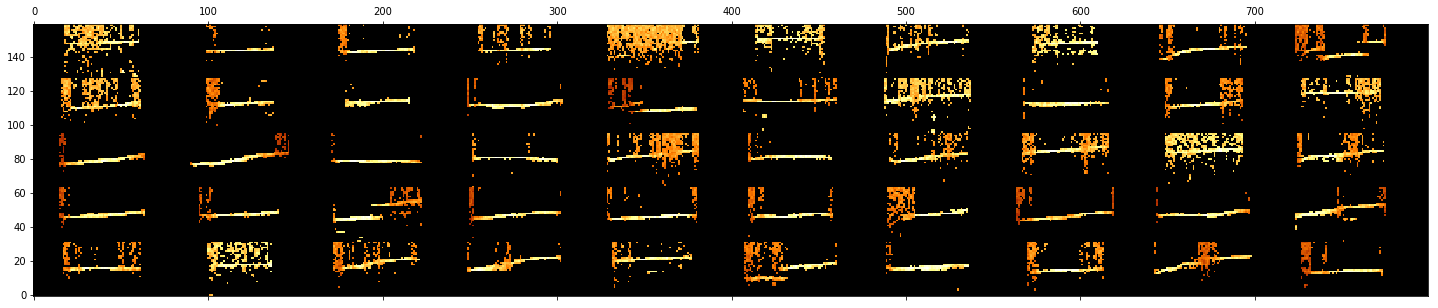

Can15-1 588
(25.0, 5) (160, 800) 25.0 32 800


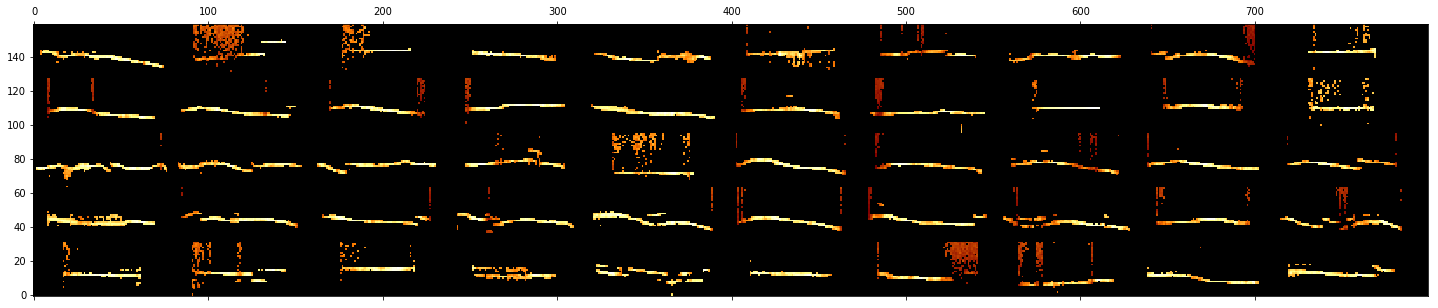

Can9-1 726
(25.0, 5) (160, 800) 25.0 32 800


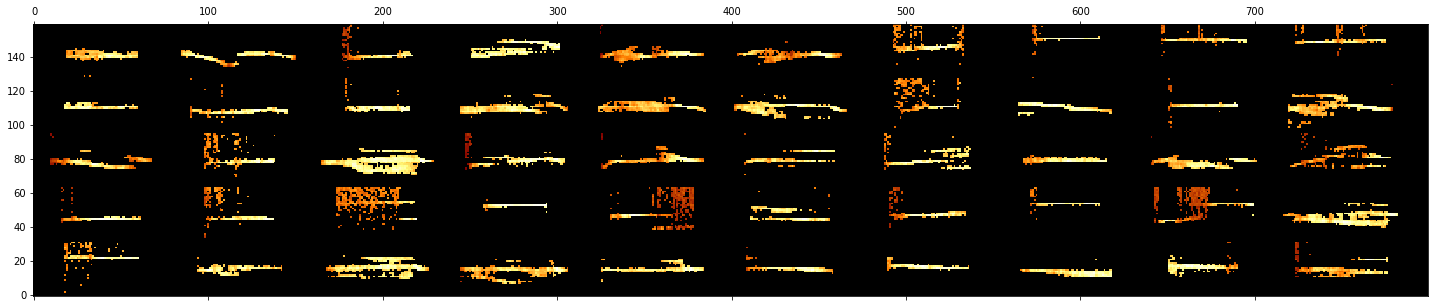

Can16-1 565
(25.0, 5) (160, 800) 25.0 32 800


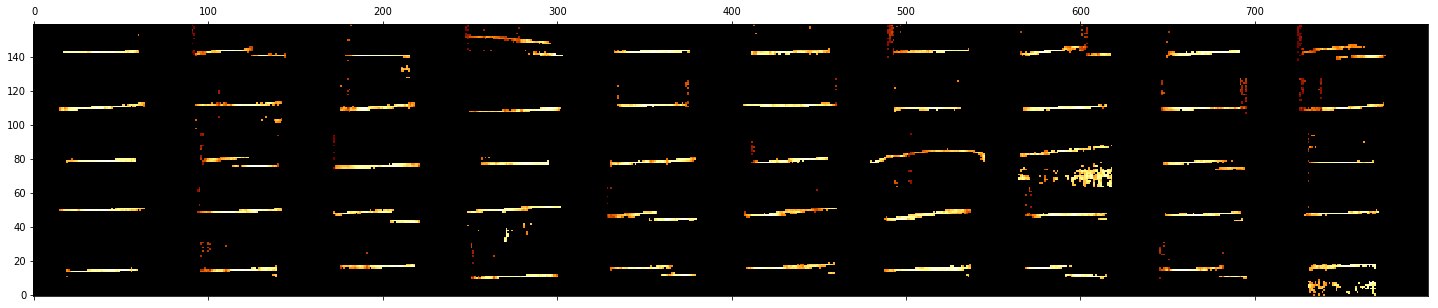

BALB128 168
(25.0, 5) (160, 800) 25.0 32 800


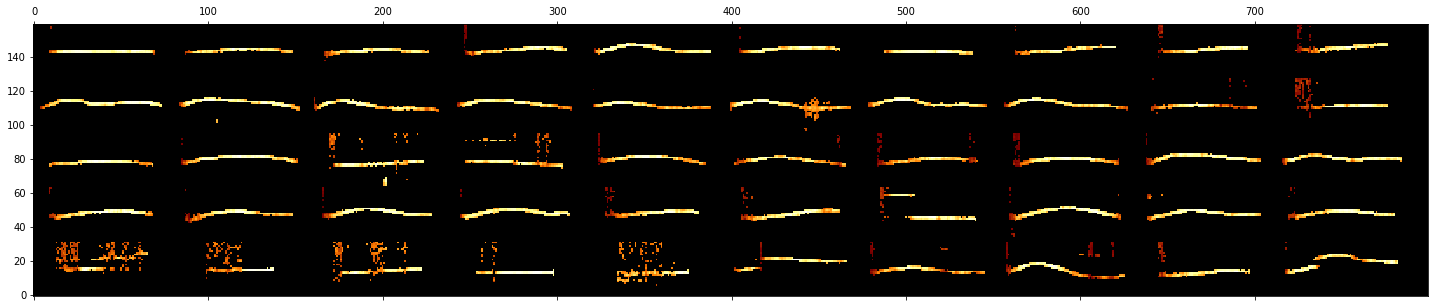

In [169]:
for indv in tqdm(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv== indv))
    specs = syllable_df[syllable_df.indv== indv].spectrogram.values
    specs = [i/np.max(i) for i in specs if np.max(i) > 0.4]
    draw_spec_set(specs, zoom=1, maxrows=5, colsize=25)
    plt.show()
    #break

### save syllable dataframe

In [170]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'mouse.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)